In [1]:
from src import DataGenerator
from src import KalmanFilter
from src import PlotFunctions

from datetime import datetime, timedelta
import numpy as np

## Parameters

In [2]:
date_start = datetime(2022, 1, 1)
date_end = datetime(2022, 7, 31)

initial_value = 6
cov_matrix = 0.3
sampling_variance = 0.5 #1.5
seed = 40

## Generate Time-Series

In [3]:
time_series = DataGenerator.SingleLognormalTimeSeries(
    date_start,
    date_end,
    initial_value,
    cov_matrix,
    sampling_variance, 
    seed
)

time_series.generate_time_series()
df = time_series.time_series_data

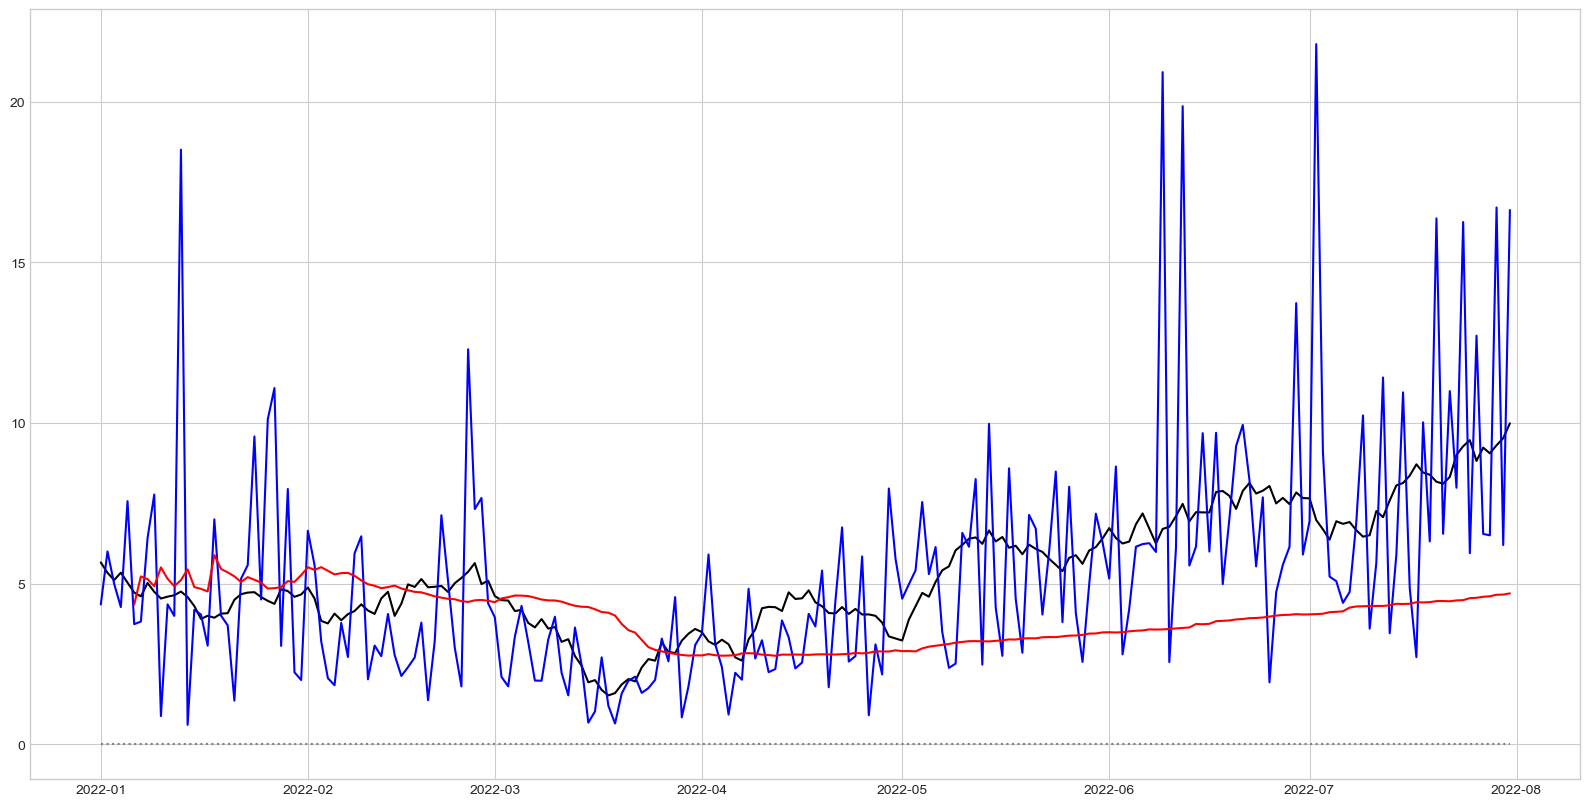

In [4]:
kf = KalmanFilter.KalmanFilterModel(time_variance=0.001, value_col_name='sampled_value')
forecast_df = kf.apply_kf(time_series.time_series_data)
forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
PlotFunctions.simple_plot(forecast_df, 'ts', obs_col='sampled_value')

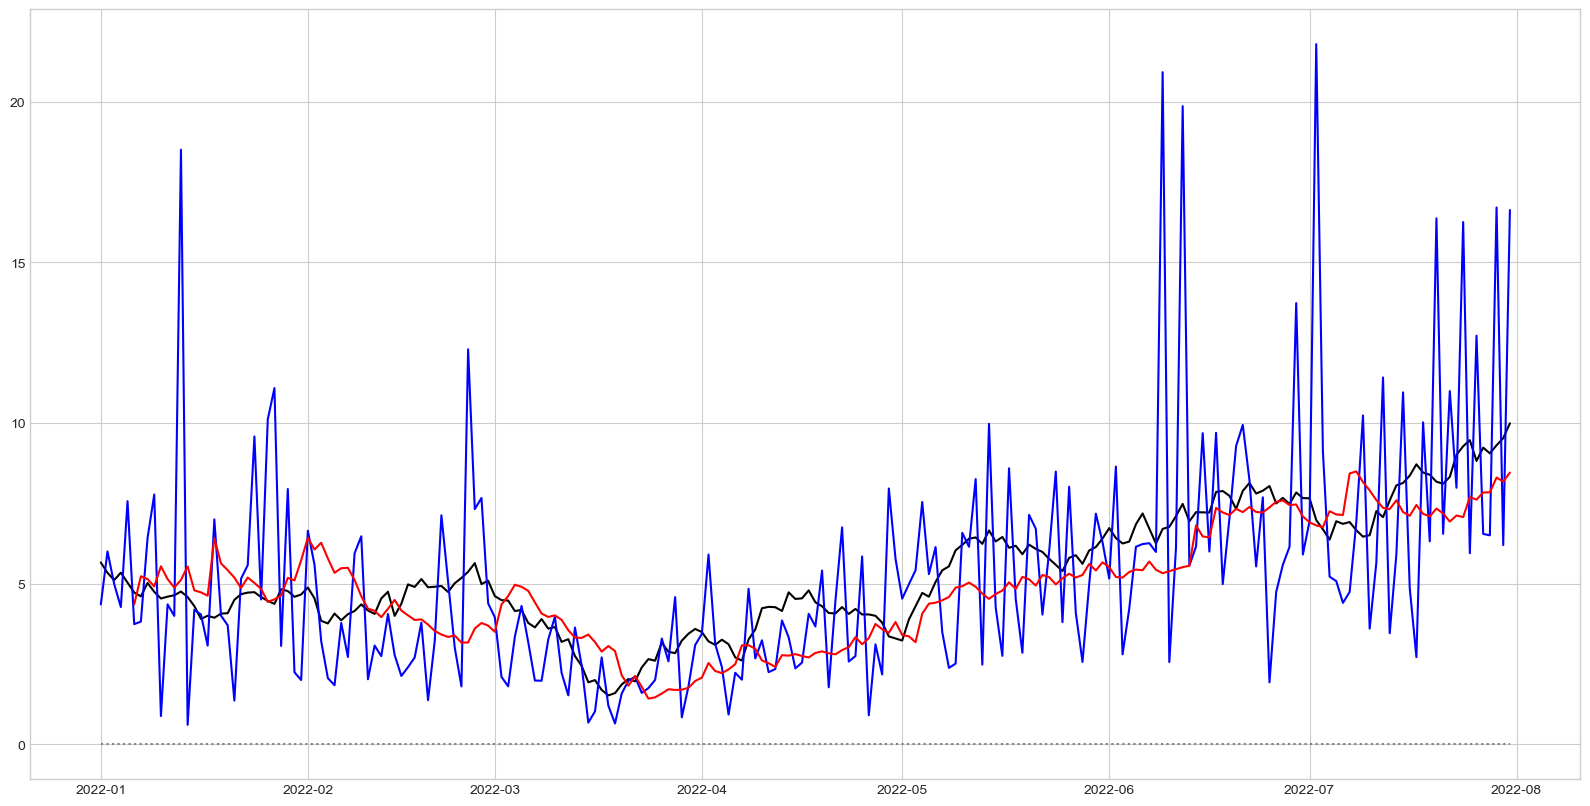

In [5]:
kf = KalmanFilter.KalmanFilterModel(time_variance=0.1, value_col_name='sampled_value')
forecast_df = kf.apply_kf(time_series.time_series_data)
forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
PlotFunctions.simple_plot(forecast_df, 'ts', obs_col='sampled_value')

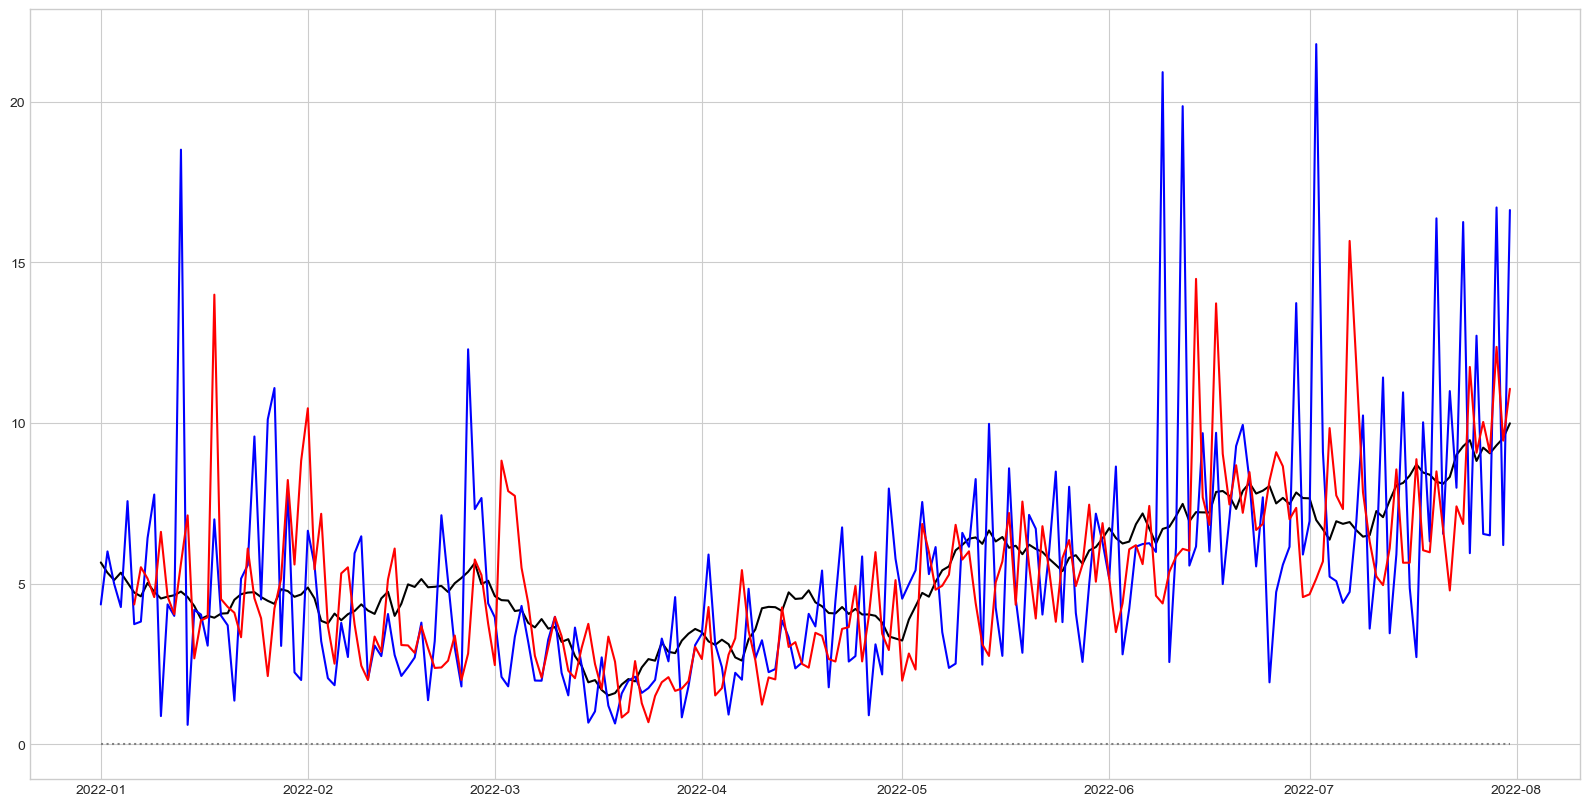

In [6]:
kf = KalmanFilter.KalmanFilterModel(time_variance=10, value_col_name='sampled_value')
forecast_df = kf.apply_kf(time_series.time_series_data)
forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
PlotFunctions.simple_plot(forecast_df, 'ts', obs_col='sampled_value')

## Find optimal calibration for time variance for the KF

In [7]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
def kf_error(time_var):
    kf = KalmanFilter.KalmanFilterModel(time_variance=time_var, value_col_name='sampled_value')
    forecast_df = kf.apply_kf(time_series.time_series_data)
    forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
    df = forecast_df.copy().dropna()
    return mean_squared_error(df['updated_value'], df['sampled_value'])

optim = minimize(kf_error, 0.1, constraints = {'type': 'ineq', 'fun': lambda x:  x[0]})
optim

     fun: 10.84030311199818
     jac: array([0.00121629])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.10158008])

In [9]:
def ideal_kf_error(time_var):
    kf = KalmanFilter.KalmanFilterModel(time_variance=time_var, value_col_name='sampled_value')
    forecast_df = kf.apply_kf(time_series.time_series_data)
    forecast_df['updated_value'] = forecast_df['updated_value'].shift(5)
    df = forecast_df.copy().dropna()
    return mean_squared_error(df['updated_value'], df['unknown_value'])

optim = minimize(ideal_kf_error, 0.1, constraints = {'type': 'ineq', 'fun': lambda x:  x[0]})
optim

     fun: 1.218095392757887
     jac: array([0.00107275])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.1222986])